# Use Structured Outputs from Provider
- Modified: 19 Nov 2025
- An easier way to get a pydantic model using strictjson's schema, and plug into your favourite provider's structured output

In [1]:
from dotenv import load_dotenv
# put your secret keys in your .env
# For instance, if you are using OpenAI, your .env should contain
# export OPENAI_API_KEY = "sk-......."
load_dotenv()

True

In [2]:
from strictjson.llm import openai_sync, openai_async
from strictjson import convert_schema_to_openai_pydantic
import os

# Method 1: DIY 
- Run `convert_schema_to_pydantic` on strictjson schema to get a pydantic model, then input either the pydantic model, or the json schema to the llm provider
- Note: **OpenAI API Structured Output does not accept `Any` or `dict` datatype**, hence use `convert_schema_to_openai_pydantic` to automatically convert Any to str, and dict[T1, T2] to [{"key": "T1", "value": "T2"}]
- Make sure the key names do not contain spaces. To be safe, keep it to alphanumeric and - and _
- Refer to strictjson/llm for examples of how to integrate strictjson schema conversion to your LLM provider
- If you would like, you could contribute your own schema conversion for your llm to strictjson. This would make it easy for people to use strictjson schema directly on your llm. Sound out on the discord group to let me know if you would like to: [John's AI Group on Discord](https://discord.gg/bzp87AHJy5)

In [3]:
from strictjson import convert_schema_to_pydantic, convert_schema_to_openai_pydantic

output_format = {"name": "Name of birthday party, str",
                     "date": "Any date in Mar 2026, date",
                     "participants": [{'Name': 'starting with A, str', 
                                       'Age': 'between 5 to 12, int'}]}

# This is preferred, can be used for gemini models
# pydantic_model = convert_schema_to_pydantic(output_format)

# This is used for OpenAI structured output, which accepts a narrow range of pydantic models
pydantic_model = convert_schema_to_openai_pydantic(output_format)

In [4]:
# use this code if you need json schema
pydantic_model.model_json_schema()

{'$defs': {'PydanticModelEc2f9e2dce4441598dc6bdc340dff2abParticipants': {'additionalProperties': False,
   'properties': {'Name': {'description': 'starting with A',
     'title': 'Name',
     'type': 'string'},
    'Age': {'description': 'between 5 to 12',
     'title': 'Age',
     'type': 'integer'}},
   'required': ['Name', 'Age'],
   'title': 'PydanticModelEc2f9e2dce4441598dc6bdc340dff2abParticipants',
   'type': 'object'}},
 'additionalProperties': False,
 'properties': {'name': {'description': 'Name of birthday party',
   'title': 'Name',
   'type': 'string'},
  'date': {'description': 'Any date in Mar 2026',
   'format': 'date',
   'title': 'Date',
   'type': 'string'},
  'participants': {'items': {'$ref': '#/$defs/PydanticModelEc2f9e2dce4441598dc6bdc340dff2abParticipants'},
   'title': 'Participants',
   'type': 'array'}},
 'required': ['name', 'date', 'participants'],
 'title': 'pydantic_model_ec2f9e2dce4441598dc6bdc340dff2ab',
 'type': 'object'}

# Method 2: Use the in-built functions `openai_sync`, `openai_async`, `gemini_sync`, `gemini_async`
- We define the llm, so just put in .env the required values,
- For OpenAI API, environment values are `OPENAI_API_KEY` and `OPENAI_BASE_URL` (optional)
    - We can use the OpenAI API for other non-OpenAI LLMs as well if it is supported, by just configuring the `OPENAI_BASE_URL` for that provider
- For Gemini API, environment values are `GEMINI_API_KEY` (default - there are other methods for credentials, check out Gemini Documentation)

- Gemini API is able to process a wider range of `output_format`, including `Any` type and `dict` type, use this if you are using Gemini models

## Example Sync and Async Usage

In [5]:
# First define your llm
from strictjson.llm import openai_sync, openai_async, gemini_sync, gemini_async

llm_sync = openai_sync
llm_async = openai_async
kwargs = {"model": "gpt-4o-mini"} # any extra parameters for the llm

# Can also try for Gemini LLM
# llm_sync = gemini_sync
# llm_async = gemini_async
# kwargs = {"model": "gemini-2.5-flash"} # any extra parameters for the llm

In [6]:
res = llm_sync(system_prompt = "You are a helpful assistent",
    user_prompt = "Generate a birthday event for Alex",
    output_format = {"name": "Name of birthday party, str",
                     "date": "Any date in Mar 2026, date",
                     "participants": [{'Name': 'starting with A, str', 
                                       'Age': 'between 5 to 12, int'}]},
                 **kwargs)

In [7]:
res

{'name': "Alex's Birthday Party",
 'date': datetime.date(2026, 3, 15),
 'participants': [{'Name': 'Alice', 'Age': 10},
  {'Name': 'Anna', 'Age': 9},
  {'Name': 'Aiden', 'Age': 11}]}

In [8]:
res = await llm_async(system_prompt = "You are a helpful assistent",
    user_prompt = "Generate a birthday event for Alex",
    output_format = {"name": "Name of birthday party, str",
                     "date": "Any date in Mar 2026, date",
                     "participants": [{'Name': 'starting with A, str', 
                                       'Age': 'between 5 to 12, int'}]},
                    **kwargs)

In [9]:
res

{'name': "Alex's Birthday Party",
 'date': datetime.date(2026, 3, 15),
 'participants': [{'Name': 'Alice', 'Age': 7},
  {'Name': 'Andrew', 'Age': 9},
  {'Name': 'Amy', 'Age': 6},
  {'Name': 'Aiden', 'Age': 11},
  {'Name': 'Ava', 'Age': 10}]}

# Also supports pydantic model direct input via `pydantic_model` parameter

In [10]:
from typing import List
from pydantic import BaseModel, Field
from datetime import date as Date

class Participant(BaseModel):
    Name: str = Field(..., description="starting with A")
    Age: int = Field(..., description="between 5 to 12")

class CalendarEvent(BaseModel):
    name: str = Field(..., description="Name of birthday party")
    date: Date = Field(..., description="Any date in March 2026")
    participants: List[Participant]

In [11]:
res = llm_sync(system_prompt = "You are a helpful assistent",
    user_prompt = "Generate a birthday event for Alex",
    pydantic_model = CalendarEvent,
                 **kwargs)

In [12]:
res

{'name': "Alex's Birthday Party",
 'date': datetime.date(2026, 3, 15),
 'participants': [{'Name': 'Alice', 'Age': 10},
  {'Name': 'Adam', 'Age': 8},
  {'Name': 'Avery', 'Age': 11},
  {'Name': 'Andrew', 'Age': 9},
  {'Name': 'Amber', 'Age': 7}]}

# If you do not want structured output, just leave out output_format

In [13]:
res = llm_sync(system_prompt = "You are a helpful assistent",
    user_prompt = "Generate a greeting card for Alex's birthday",
                 **kwargs)

In [14]:
print(res)

**Front of Card:**

🎉🎂 Happy Birthday, Alex! 🎂🎉  

*(Colorful balloons and confetti graphics)*

---

**Inside of Card:**

Hey Alex!  

Wishing you a day filled with laughter, joy, and all your favorite things. May this year bring you new adventures, amazing memories, and endless happiness.  

You deserve all the best on your special day!  

Cheers to another fantastic year ahead!  

With love,  
[Your Name]  

*(Optional: Include a fun birthday quote or a personal touch like a favorite memory)*


## Complex Output Format Test

In [15]:
# Gemini API
res = gemini_sync(system_prompt = "Give me 5 names on a topic", 
           user_prompt = "weather",
           output_format = {"Names": "Great sounding names, List[str]",
                            "Meanings": "Name and meaning, dict", 
                            "Chinese_Meanings": "Name and meaning in chinese, dict",
                            "Lucky_Name_and_Number": "3 names and 2 numbers, list",
                            "Code": "Python code to generate 5 names, str",
                            "Sentiment": "Enum['Happy', 'Sad', 'Other']",
                            "Sentiment_Scale": "Scale of 1 (Bored) to 5 (Excited), Enum[1, 2, 3, 4, 5]"},
                 model = "gemini-2.5-flash")

In [16]:
res

{'Names': ['Rain', 'Cloud', 'Storm', 'Breeze', 'Sun'],
 'Meanings': {'Rain': 'Precipitation in the form of water droplets',
  'Cloud': 'A visible mass of condensed water vapor floating in the atmosphere',
  'Storm': 'A violent disturbance of the atmosphere with strong winds and usually rain, thunder, lightning, or snow',
  'Breeze': 'A gentle wind',
  'Sun': 'The star that the Earth orbits, providing light and heat'},
 'Chinese_Meanings': {'Rain': '雨 (yǔ)',
  'Cloud': '云 (yún)',
  'Storm': '风暴 (fēng bào)',
  'Breeze': '微风 (wēi fēng)',
  'Sun': '太阳 (tài yáng)'},
 'Lucky_Name_and_Number': ['Storm', 'Sun', 'Breeze', 7, 3],
 'Code': "import random\n\nweather_names = ['Rain', 'Cloud', 'Storm', 'Breeze', 'Sun', 'Wind', 'Snow', 'Thunder', 'Mist', 'Dew']\n\ndef generate_weather_names(count=5):\n    return random.sample(weather_names, count)\n\nnames = generate_weather_names()",
 'Sentiment': 'Other',
 'Sentiment_Scale': 3}

In [17]:
# OpenAI API - Compare with Gemini API
# For OpenAI API, Note the Lucky_Name_and_Number is not parsed as int and str but instead all processed as str (type Any is not allowed)
# For OpenAI API, Note also that Chinese_Meanings is not parsed as dict, but as List[{"key": "str", "value": "str"}], because dict is not allowed in openai structured output

res = openai_sync(system_prompt = "Give me 5 names on a topic", 
           user_prompt = "weather",
           output_format = {"Names": "Great sounding names, List[str]",
                            "Meanings": "Name and meaning, dict", 
                            "Chinese_Meanings": "Name and meaning in chinese, dict",
                            "Lucky_Name_and_Number": "3 names and 2 numbers, list",
                            "Code": "Python code to generate 5 names, str",
                            "Sentiment": "Enum['Happy', 'Sad', 'Other']",
                            "Sentiment_Scale": "Scale of 1 (Bored) to 5 (Excited), Enum[1, 2, 3, 4, 5]"},
                 model = "gpt-5.1")

In [18]:
res

{'Names': ['Zephyris', 'Nimbaro', 'Cyrastra', 'Pluvion', 'Solandra'],
 'Meanings': [{'key': 'Zephyris',
   'value': 'Inspired by a gentle west wind, light and refreshing like a spring breeze.'},
  {'key': 'Nimbaro',
   'value': 'Evokes towering rain clouds; powerful, dramatic, and full of energy.'},
  {'key': 'Cyrastra',
   'value': 'Clear, starry night sky after a storm; calm, bright, and mystical.'},
  {'key': 'Pluvion',
   'value': 'Drawn from rain itself; soothing, rhythmic, and nurturing to life.'},
  {'key': 'Solandra',
   'value': 'Sunlit warmth after heavy clouds; radiant, steady, and reassuring.'}],
 'Chinese_Meanings': [{'key': 'Zephyris', 'value': '源自“西风”，像春风般轻柔清新'},
  {'key': 'Nimbaro', 'value': '让人联想到高耸的雨云，力量十足、气势磅礴'},
  {'key': 'Cyrastra', 'value': '暴雨过后宁静的星空，宁和明亮，略带神秘感'},
  {'key': 'Pluvion', 'value': '来自“雨”的意象，温柔有节奏，滋养万物'},
  {'key': 'Solandra', 'value': '乌云散去后的阳光，明朗、稳定并带来安全感'}],
 'Lucky_Name_and_Number': ['Zephyris', 'Cyrastra', 'Solandra', '7', '18'],
 'Code': 'import

# Process images via url
- Simply envelop the `<<file_path>>` or `<<file_url>>` with double angle brackets `<<` and `>>`

In [19]:
from IPython.display import HTML

img1_url = "https://github.com/tanchongmin/agentjo/blob/main/projects/Pokemon/Game/map1.png?raw=true"
img2_url = "https://github.com/tanchongmin/agentjo/blob/main/projects/Pokemon/Game/map2.png?raw=true"

HTML(f"""
<div style="display: flex; gap: 10px;">
  <img src="{img1_url}" width="25%">
  <img src="{img2_url}" width="25%">
</div>
""")

In [20]:
# Use the two urls to understand the images
res = llm_sync('''You are a friendly assistant to play a game for the player. 
You are to describe what happened in previous game states.
Pay particular attention to the tiles of the game and the position of the players.''',
      f"Previous state 1: <<{img1_url}>>, state 2: <<{img2_url}>>",
      output_format = {"State_1": "Describe first state, str",
                      "State_2": "Describe second state, str",
                      "Thoughts": "Describe what is happening, str"},
                 **kwargs)

In [21]:
res

{'State_1': "In the first state, the player character is positioned slightly left of center with an orange outfit. Two characters in green outfits are visible: one above the player and another to the left. There's also a character with blue hair and a blue outfit in the lower right corner near a sign that reads 'EXIT'. The surrounding terrain is rocky and dark.",
 'State_2': 'In the second state, the player character remains in the same position, but the green character above has moved slightly to the right, indicating a movement up. The character with the blue hair and outfit still stands near the sign at the bottom right, and the surrounding rocky terrain of the area continues to appear dark.',
 'Thoughts': 'The player character is navigating the rocky terrain, possibly looking to interact with the blue character or examine the sign. The movement of the green character suggests that the player is exploring or going through the area. It feels like a transition phase as the player asse

In [22]:
# Use the two urls to understand the images
res = await llm_async('''You are a friendly assistant to play a game for the player. 
You are to describe what happened in previous game states.
Pay particular attention to the tiles of the game and the position of the players.''',
      f"Previous state 1: <<{img1_url}>>, state 2: <<{img2_url}>>",
      output_format = {"State_1": "Describe first state, str",
                      "State_2": "Describe second state, str",
                      "Thoughts": "Describe what is happening, str"},
                 **kwargs)

In [23]:
res

{'State_1': "In the first state, the player character, dressed in orange, is positioned on a horizontal pathway with two green characters nearby, one above and one below. There's a character in blue off to the right beside a sign.",
 'State_2': 'In the second state, the player character remains on the same pathway, now slightly moved forward, while the green character above has shifted further up. The blue character is still present on the right alongside the sign.',
 'Thoughts': 'The player seems to be navigating through the area, possibly exploring or approaching the blue character for interaction or further dialogue.'}

# Process Images via FilePath

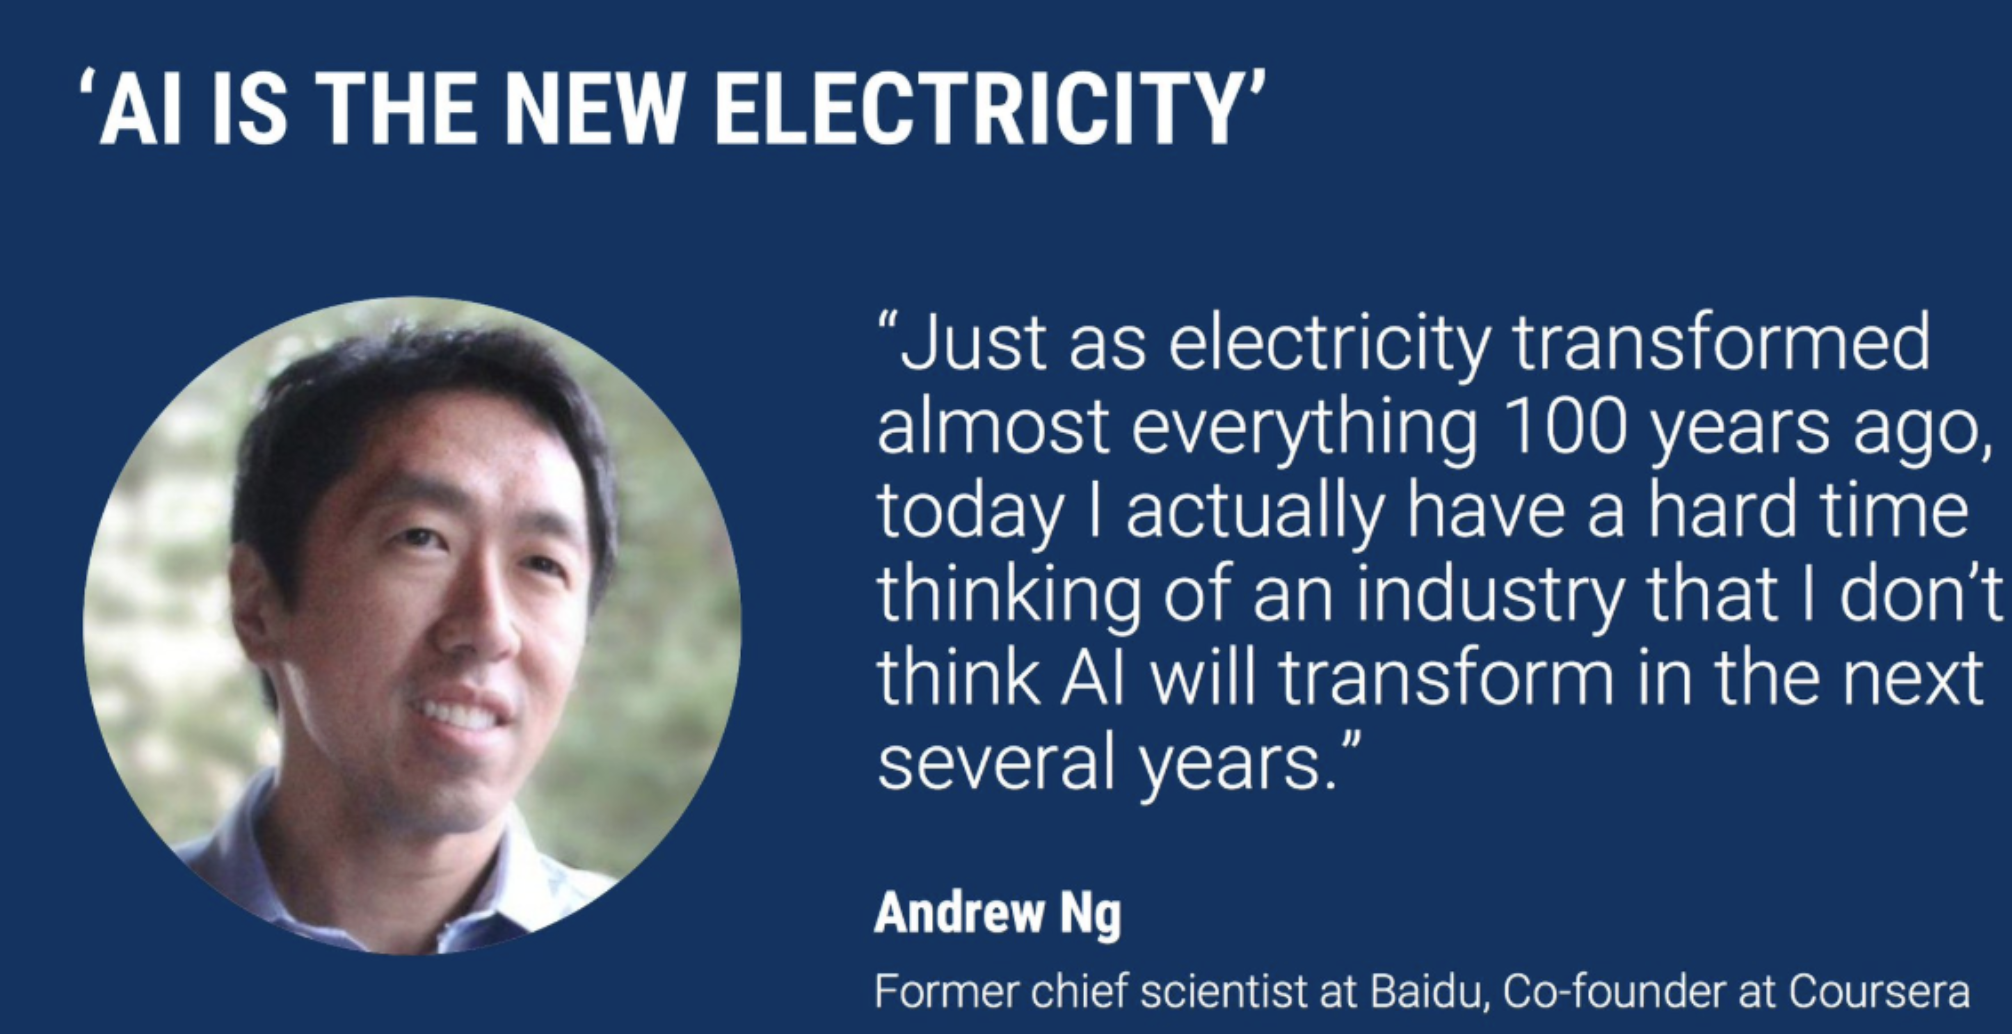

In [24]:
from IPython.display import Image, display

filepath = "ai_electricity.png"
display(Image(filename=filepath, width = 500))

In [25]:
# Use the filepath to understand the image
res = llm_sync(system_prompt = '''Output all text on the image and give an overall description''',
      user_prompt = f"Image: <<{filepath}>>",
      output_format = {"Image_Text": "Output word for word all the text on the image, str",
                      "Image_Description": "Describe the overall image, str"},                 
                 **kwargs)

In [26]:
res

{'Image_Text': '‘AI IS THE NEW ELECTRICITY’\n\n"Just as electricity transformed almost everything 100 years ago, today I actually have a hard time thinking of an industry that I don’t think AI will transform in the next several years." \n\nAndrew Ng\nFormer chief scientist at Baidu, Co-founder at Coursera.',
 'Image_Description': "The image features a blue background with a circular photo of a man on the left. To the right, there is a quote stating the transformative impact of AI, compared to electricity, emphasizing its future influence across various industries. The man's name and title are also included at the bottom."}

In [27]:
# Use the filepath to understand the images
res = await llm_async(system_prompt = '''Output all text on the image and give an overall description''',
      user_prompt = f"Image: <<{filepath}>>",
      output_format = {"Image_Text": "Output word for word all the text on the image, str",
                      "Image_Description": "Describe the overall image, str"},
                **kwargs)

In [28]:
res

{'Image_Text': '\'AI IS THE NEW ELECTRICITY\' "Just as electricity transformed almost everything 100 years ago, today I actually have a hard time thinking of an industry that I don’t think AI will transform in the next several years." Andrew Ng Former chief scientist at Baidu, Co-founder at Coursera.',
 'Image_Description': 'The image features a quote by Andrew Ng, placed on a dark blue background. It includes a circular photograph of Ng on the left side. The quote discusses the transformative potential of AI, comparing it to the impact of electricity a century ago.'}